In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F   
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.nn.utils import clip_grad_value_
from torchvision import datasets
from torchvision.utils import make_grid   
from torchvision import transforms
# from torchvision.models.detection import 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib.inline

import os
import time
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


UsageError: Line magic function `%matplotlib.inline` not found.


## Importing and splitting the data into train and test

In [96]:
data_dir = r'/Users/Desktop/DeskTop/jupyter notebook/horizontal projects/satellite_image_recognition/satellite_images/data/train_images_datasets/data'
os.listdir(data_dir)


['forest',
 'cloudy',
 'buildings',
 'river',
 'mobilehomepark',
 '.DS_Store',
 'harbor',
 'water',
 'golfcourse',
 'agricultural',
 'runway',
 'baseballdiamond',
 'overpass',
 'chaparral',
 'tenniscourt',
 'intersection',
 'airplane',
 'parkinglot',
 'sparseresidential',
 'green_area',
 'mediumresidential',
 'denseresidential',
 'beach',
 'desert',
 'freeway',
 'storagetanks']

In [97]:

stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.2])   

train_trans = transforms.Compose([
                    transforms.RandomCrop(64, padding=4, padding_mode='reflect'),  
                    transforms.RandomRotation(30),
                    transforms.RandomHorizontalFlip(),
                    transforms.Resize(size=(64,64)),
                    transforms.ToTensor(),
                    transforms.Normalize(*stats, inplace=True)   
                    
])
valid_trans = transforms.Compose([
                    transforms.Resize(size=(64,64)),
                    transforms.ToTensor(),
                    transforms.Normalize(*stats)
])




In [98]:
train_data = datasets.ImageFolder(data_dir, transform=train_trans)
valid_data = datasets.ImageFolder(data_dir, transform=valid_trans)


In [99]:
data_set = datasets.ImageFolder(data_dir, transform=train_trans)
num_train = len(data_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2* num_train))
train_idx, val_idx = indices[split:], indices[:split]
dataset_size = {'train':len(train_idx), 'val':len(val_idx)}

# sampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


## loading data interpretation loader

In [100]:
train_dl = DataLoader(train_data, batch_size=8, sampler=train_sampler)

valid_dl = DataLoader(valid_data, batch_size=8, sampler=val_sampler)


In [101]:
data_sizes = {'train': len(train_dl.sampler), 'val':len(valid_dl.sampler)}
data_sizes

{'train': 12905, 'val': 3226}

In [102]:
class_names = train_dl.dataset.classes
class_names

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'cloudy',
 'denseresidential',
 'desert',
 'forest',
 'freeway',
 'golfcourse',
 'green_area',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt',
 'water']

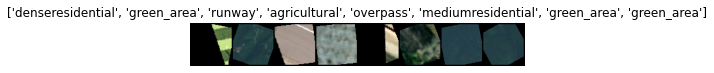

In [103]:
def batch_show(imgs, title):
    mean_value = [0.485, 0.456, 0.406]
    std_value = [0.229, 0.224, 0.2]
    
    mean = torch.tensor(mean_value).reshape(1,3,1,1)
    std = torch.tensor(std_value).reshape(1,3,1,1)
    
    image_denormalize = std*imgs + mean
    
    image_ = make_grid(image_denormalize).permute(1,2,0)
    
    fig = plt.figure(200)
    ax = plt.imshow(image_)
    plt.title(label=title, loc='center')
    plt.axis('off')
    
batch_sample, classes = next(iter(train_dl))
batch_show(batch_sample, title=[class_names[i] for i in classes])    
    

In [104]:
batch_sample.shape

torch.Size([8, 3, 64, 64])

## setting device and make the data into

In [105]:
def get_default_device():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#     device = torch.device('cpu')
    return device

def to_device(batch, device):
    if isinstance(batch, (list, tuple)):
        return [to_device(x, device) for x in batch]
    return batch.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
             
    def __len__(self):
        return len(self.dl)
          
    

In [106]:
curr_device = get_default_device()
train_dl = DeviceDataLoader(train_dl, curr_device)
val_dl = DeviceDataLoader(valid_dl, curr_device)
dataloaders = {'train':train_dl, 'val':val_dl}
curr_device

device(type='cpu')

In [107]:
next(iter(dataloaders['train']))

[tensor([[[[-2.1179, -2.1179, -2.1179,  ...,  1.5468, -2.1179, -2.1179],
           [-2.1179,  1.1358,  1.1015,  ...,  1.5982,  1.5810, -2.1179],
           [ 1.1529,  1.1015,  1.0844,  ...,  1.5982,  1.5810, -2.1179],
           ...,
           [-2.1179, -0.0458, -0.0458,  ...,  0.9988,  1.1187,  1.0502],
           [-2.1179,  0.0227,  0.0056,  ...,  0.9817,  1.0844, -2.1179],
           [-2.1179, -2.1179,  0.1426,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ...,  1.5007, -2.0357, -2.0357],
           [-2.0357,  0.9055,  0.8704,  ...,  1.5007,  1.5182, -2.0357],
           [ 0.9230,  0.8880,  0.8529,  ...,  1.5182,  1.5357, -2.0357],
           ...,
           [-2.0357, -0.0924, -0.1099,  ...,  0.8179,  0.9230,  0.8704],
           [-2.0357,  0.0301, -0.0399,  ...,  0.7829,  0.9055, -2.0357],
           [-2.0357, -2.0357,  0.1877,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-2.0300, -2.0300, -2.0300,  ...,  1.6759, -2.0300, -2.0300],
           [-

## establish a NN model (Residual block)

### SimAM attention

In [108]:


class SimAM(nn.Module):
    def __init__(self, e_lambda=1e-4):
        super(SimAM, self).__init__()

        self.activaton = nn.Sigmoid()
        self.e_lambda = e_lambda

    def __repr__(self):
        s = self.__class__.__name__ + '('
        s += ('lambda=%f)' % self.e_lambda)
        return s

    @staticmethod
    def get_module_name():
        return "simam"

    def forward(self, x):
        b, c, h, w = x.size()

        n = w * h - 1

        x_minus_mu_square = (x - x.mean(dim=[2, 3], keepdim=True)).pow(2)
        y = x_minus_mu_square / (4 * (x_minus_mu_square.sum(dim=[2, 3], keepdim=True) / n + self.e_lambda)) + 0.5

        return x * self.activaton(y)

    

In [109]:

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):    
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        
        return out
    

In [110]:
model = to_device(ResNet9(3,25), curr_device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [111]:
class SimAM_resnet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        self.SimAM = SimAM()
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        SimAM_out = self.SimAM(out)
        out = self.classifier(SimAM_out)
        
        return out

In [112]:
Sim_model = to_device(SimAM_resnet9(3, 25), curr_device)
Sim_model

SimAM_resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

## Training the model

### Focal loss

In [113]:

class FocalLoss(nn.Module):

    def __init__(self):
        super(FocalLoss, self).__init__()
        self.gamma = 2
        self.eps = 1e-7
        self.ce = torch.nn.CrossEntropyLoss(weight=None, reduction='mean')

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()
    
focal_loss = FocalLoss()

In [114]:
### setting accuracy func & learning rate func

def get_accuracy(outputs, labels):
    _, preds_cls = torch.max(outputs, dim=1)  
    
    return torch.tensor(torch.sum(preds_cls == labels).item() / len(preds_cls))


def get_lr(optimizer):
    for param in optimizer.param_groups:
        return param['lr']
        

    

In [115]:
### define some relevant parameters
total_epoch = 100
init_lr = 0.01

best_loss = np.inf
grad_clip = True
adam_optimizer = torch.optim.Adam(model.parameters(),
                             lr = init_lr,
                            )
lr_sched = torch.optim.lr_scheduler.OneCycleLR(adam_optimizer,
                                               max_lr= init_lr,
                                               epochs=total_epoch,
                                               steps_per_epoch=len(train_dl)
                                              )

CE_loss = nn.CrossEntropyLoss()
FC_loss = FocalLoss()

In [116]:


def trainer(select_model, optimizer, criterion):

    # torch.cuda.empty_cache()
    start_time = time.time()

    for epoch in range(total_epoch):
        print('Epoch {}/{}'.format(epoch+1, total_epoch))
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                select_model.train
            else:
                select_model.eval()

            lr = []
            current_loss = 0.0
            train_loss_sts = []
            val_loss_sts = []

            current_acc = 0
            train_acc_sts = []
            val_acc_sts = []

            for inputs, label in tqdm(dataloaders[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = select_model(inputs)
                    loss = criterion(outputs, label)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                current_loss += loss.item()*inputs.size(0)
                current_acc += get_accuracy(outputs, label)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_acc / data_sizes[phase]

            if phase == 'val':
                val_loss_sts.append(epoch_loss)
                val_acc_sts.append(epoch_acc)
            else:
                lr.append(get_lr(adam_optimizer))
                train_loss_sts.append(epoch_loss)
                train_acc_sts.append(epoch_acc)
                print('{} Loss: {:.4f}  |  {} Accuracy: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

#             if phase == 'val' and epoch_loss < best_loss:
#                 print('Validated loss decreased from {:.4f} to {:.4f} | Saving Weights...'.format(best_loss, epoch_loss))
#                 best_loss = epoch_loss
#             else:
#                 continue
    time_period = time.time()-start_time
    print('Training complete in {:.0f}m {:.2f}s'.format(time_period//60, time_period%60))
    print('Best val loss:{:.4f}'.format(best_loss))

    return [lr, train_loss_sts, val_loss_sts, train_acc_sts, val_acc_sts]

    



In [117]:
# resnet_9、 adam_optimizer, cross_entropy
history_1 = trainer(model, adam_optimizer, CE_loss)

Epoch 1/100
----------


100%|███████████████████████████████████████| 1614/1614 [22:29<00:00,  1.20it/s]


train Loss: 2.3890  |  train Accuracy: 0.0399


100%|█████████████████████████████████████████| 404/404 [01:38<00:00,  4.11it/s]


UnboundLocalError: local variable 'best_loss' referenced before assignment

In [ ]:
# resnet_9、 adam_optimizer, Focal_loss
history_2 = trainer(model, adam_optimizer, focal_loss)

In [79]:
# resnet_9_SimAM、 adam_optimizer, Focal_loss
history_3 = trainer(Sim_model, adam_optimizer, focal_loss)

Epoch 1/100
----------


  0%|▏                                         | 6/1614 [00:05<25:52,  1.04it/s]


KeyboardInterrupt: 

## saving relevant parameters of this model

## saving relevant loss, acc info 
### history1: 原始的resnet模型     history2：resnet+Focal Loss     history3: SimAM+resnet+Focal Loss

In [140]:
history

[{'val_loss': 1.0052696466445923,
  'val_acc': 0.7090672850608826,
  'train_loss': 0.9029428362846375,
  'lrs': [0.0003999999999999993,
   0.0004000053153814971,
   0.00040002126151421867,
   0.000400047838362845,
   0.000400085045868517,
   0.00040013288394883176,
   0.00040019135249783587,
   0.00040026045138603916,
   0.00040034018046040606,
   0.00040043053954435387,
   0.0004005315284377649,
   0.0004006431469169725,
   0.00040076539473477175,
   0.00040089827162041215,
   0.0004010417772796083,
   0.00040119591139453105,
   0.0004013606736238146,
   0.00040153606360255126,
   0.0004017220809422982,
   0.0004019187252310742,
   0.00040212599603336487,
   0.0004023438928901172,
   0.000402572415318745,
   0.00040281156281313235,
   0.0004030613348436265,
   0.0004033217308570501,
   0.00040359275027669096,
   0.0004038743925023087,
   0.00040416665691014354,
   0.0004044695428528991,
   0.0004047830496597682,
   0.0004051071766364069,
   0.0004054419230649642,
   0.0004057872882040

In [70]:
history1_path = '/Users/Desktop/DeskTop/jupyter notebook/horizontal projects/satellite_image_recognition/satellite_images/PyQt/history/history_1.txt'
history2_path = '/Users/Desktop/DeskTop/jupyter notebook/horizontal projects/satellite_image_recognition/satellite_images/PyQt/history/history_2.txt'
history3_path = '/Users/Desktop/DeskTop/jupyter notebook/horizontal projects/satellite_image_recognition/satellite_images/PyQt/history/history_3.txt'
history_1 = np.loadtxt(history1_path, delimiter=',')
history_2 = np.loadtxt(history2_path, delimiter=',')
history_3 = np.loadtxt(history3_path, delimiter=',')



In [71]:
his1_df = pd.DataFrame(data=history_1).transpose()
his1_df.columns=['lr', 'train_loss1', 'val_loss1', 'train_acc1', 'val_acc1']
his1_df.to_excel('./history/history_1.xlsx')

his2_df = pd.DataFrame(data=history_2).transpose()
his2_df.columns=['lr', 'train_loss2', 'val_loss2', 'train_acc2', 'val_acc2']
his2_df.to_excel('./history/history_2.xlsx')

his3_df = pd.DataFrame(data=history_3).transpose()
his3_df.columns=['lr', 'train_loss3', 'val_loss3', 'train_acc3', 'val_acc3']
his3_df.to_excel('./history/history_3.xlsx')


## plotting 

In [73]:
his1_df

,lr,train_loss1,val_loss1,train_acc1,val_acc1
0,0.001000,10.799673,13.771291,0.436454,0.375310
1,0.001859,10.684304,13.515352,0.439941,0.380893
2,0.004109,10.589958,13.272890,0.439321,0.383685
3,0.006891,10.541590,13.716261,0.440096,0.372519
4,0.009141,10.542043,13.323665,0.441336,0.385856
5,0.001000,9.941775,13.121783,0.457920,0.392680
6,0.001035,9.883697,13.216796,0.460865,0.395161
7,0.001141,9.952960,13.541624,0.459315,0.389578
8,0.001316,9.996653,13.211351,0.462802,0.394231
9,0.001557,9.781604,13.186074,0.464275,0.390509


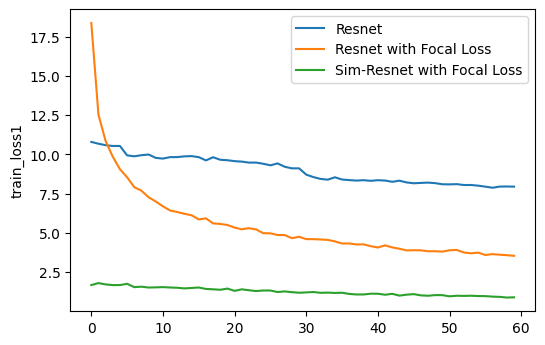

In [81]:
# loss comparasion
fig = plt.figure(dpi=100)
ax = sns.lineplot(x=his1_df.index, y=his1_df['train_loss1'], label='Resnet')
ax = sns.lineplot(x=his2_df.index, y=his2_df['train_loss2'], label='Resnet with Focal Loss')
ax = sns.lineplot(x=his3_df.index, y=his3_df['train_loss3'], label='Sim-Resnet with Focal Loss')
plt.savefig('./history/loss.png')


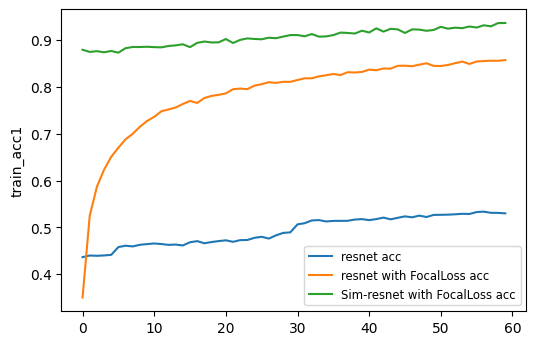

In [82]:
# acc comparasion
fig = plt.figure(dpi=100)
ax = sns.lineplot(x=his1_df.index, y=his1_df['train_acc1'], label='resnet acc')
ax = sns.lineplot(x=his2_df.index, y=his2_df['train_acc2'], label='resnet with FocalLoss acc')
ax = sns.lineplot(x=his3_df.index, y=his3_df['train_acc3'], label='Sim-resnet with FocalLoss acc')
ax.legend(loc='best', fontsize='small')
plt.savefig('./history/acc.png')


# loading params after training on the cpu not mps into Net

In [19]:
model_cpu = to_device(ResNet9(3,4), device)
model_cpu.load_state_dict(torch.load('/Users/PycharmProjects/satellite_images/PyQt/ResModel_cpu.pth', 
                                     map_location=torch.device('cpu') 
                                     ))
model_cpu.eval()                      
                          

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## testing with invidual images

In [20]:
def predict_images(img, model):
    
    # convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    
    # get prediction from model
    yb = model(xb)
    
    # pick index with highest probablity
    _, preds = torch.max(yb, dim=1)
    
    # retrieve the class label
    return preds[0].item()
    


In [1]:
model.eval()
torch.no_grad()

img, label = valid_data[0]
predict_images('img', model_cpu)


NameError: name 'model' is not defined

In [22]:
model.eval()
torch.no_grad()
test_path = r'/Users/PycharmProjects/satellite_images/data/train_images_datasets/data/cloudy/train_437.jpg'

img1 = Image.open(test_path).convert('RGB')   

test_image1 = train_trans(img1)
predict_images(test_image1, model_cpu)




0

In [258]:
for i in train_dl:
    print(i)
    break

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-2.0300, -2.0300, -2.0300,  ..., -2.0300, -2.0300, -2.0300],
          [-2.0300, -2.0300, 

## making the classification report

In [178]:
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in tqdm(valid_dl):
        test_images, test_labels = test_data
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [01:38<00:00,  3.56it/s]


In [179]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1500
           1       0.96      0.98      0.97      1131
           2       0.83      0.95      0.88      1500
           3       0.94      0.79      0.86      1500

    accuracy                           0.92      5631
   macro avg       0.93      0.92      0.92      5631
weighted avg       0.92      0.92      0.92      5631



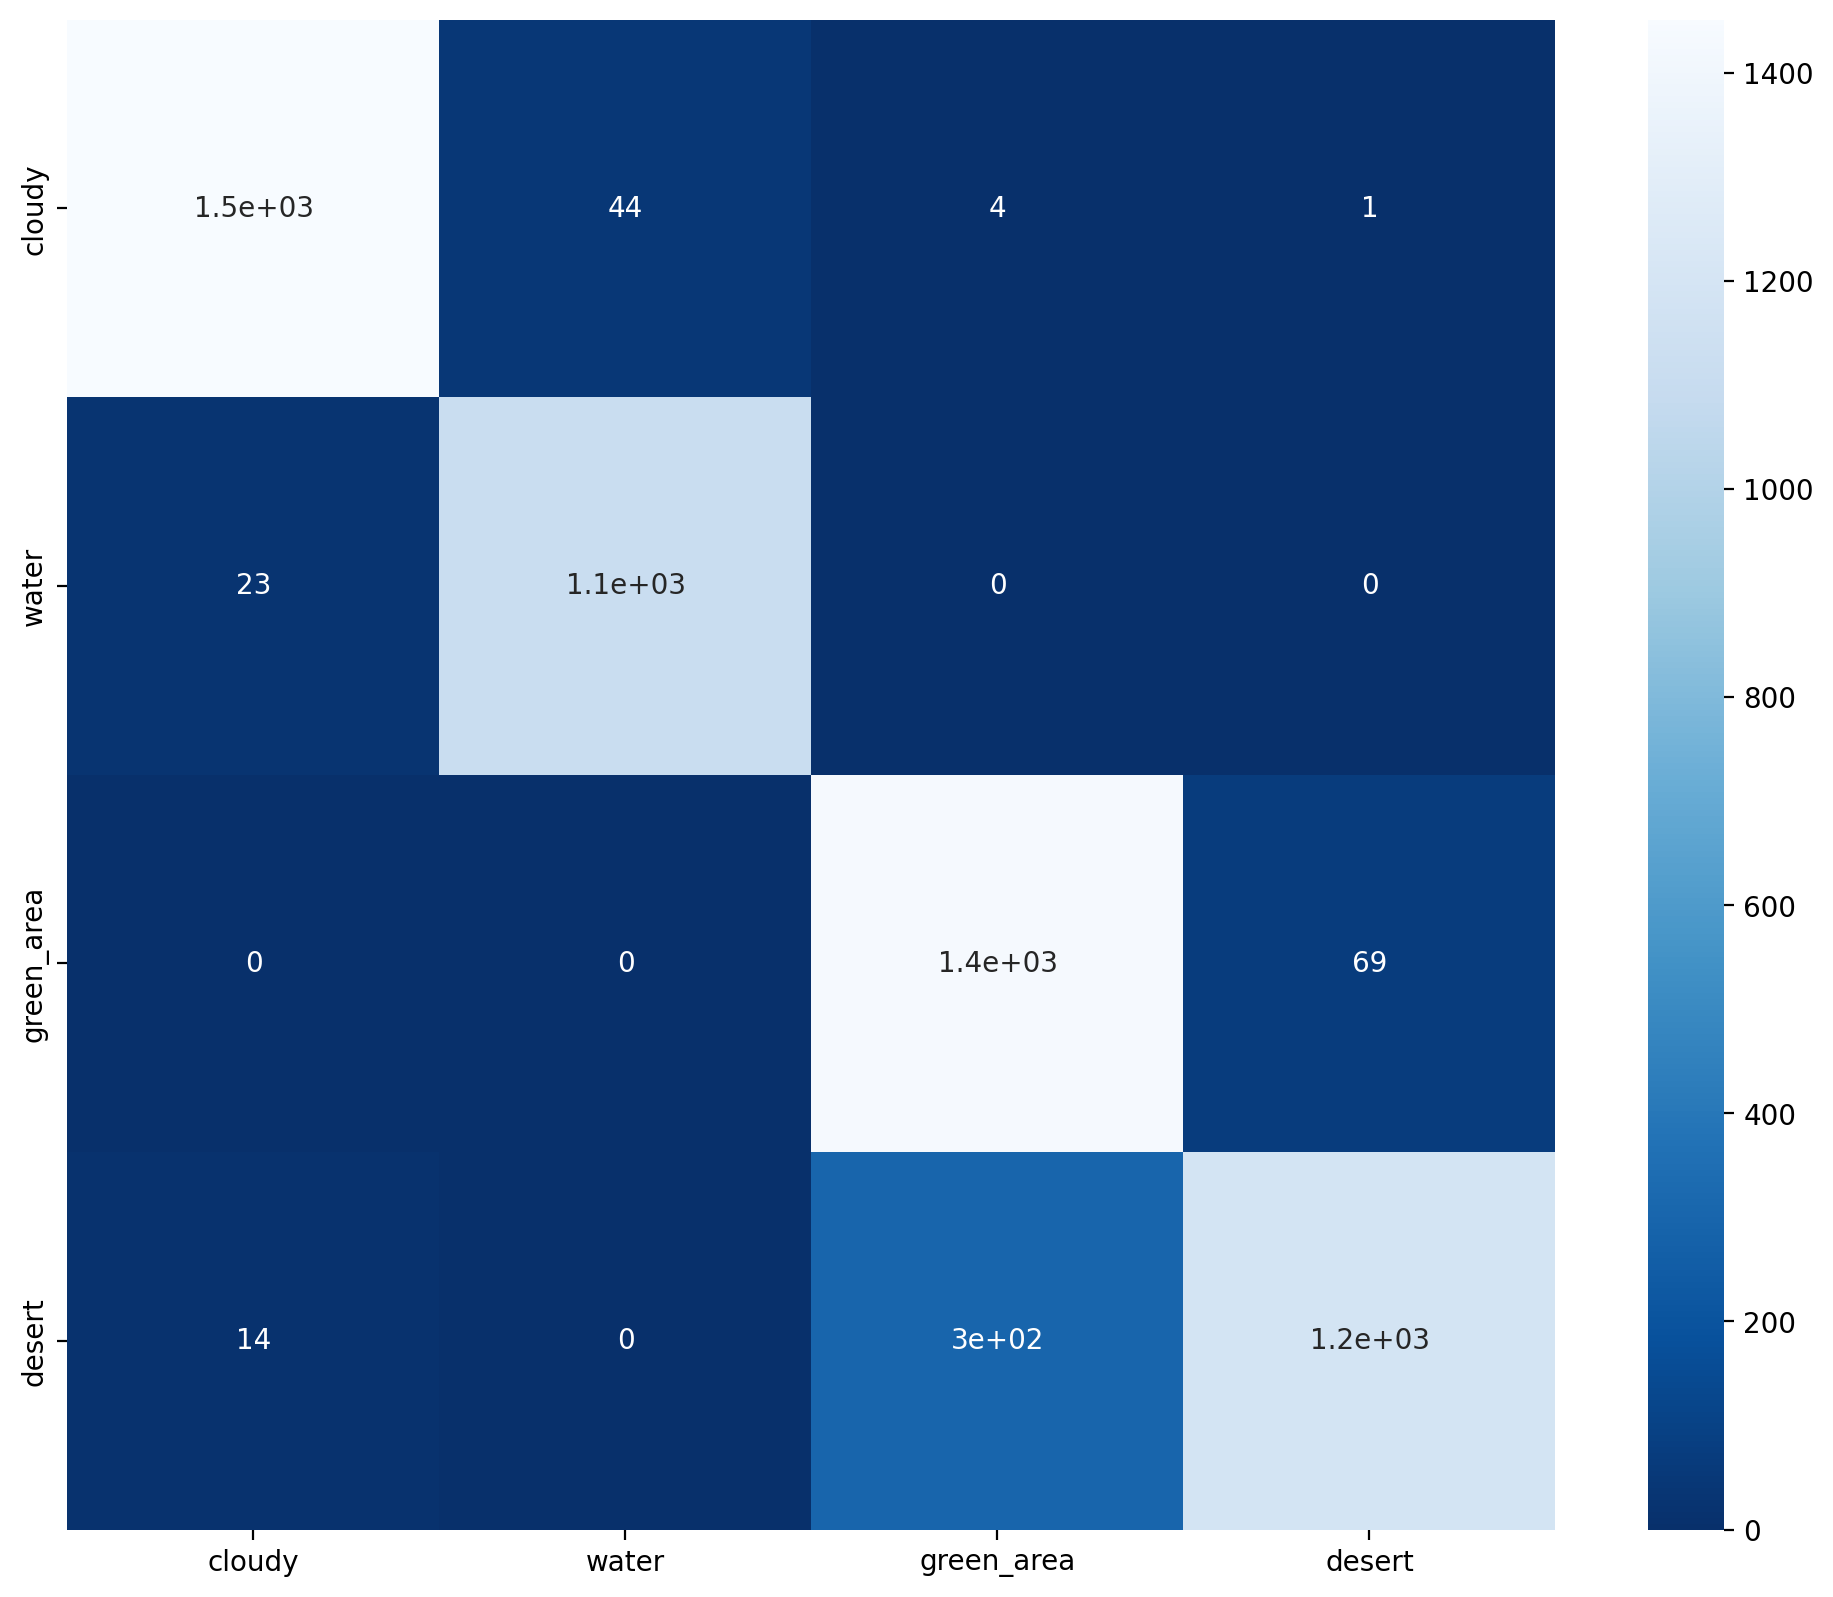

In [218]:
# plot confusion_matrix
cm = confusion_matrix(y_true, y_pred)
image_varieties = ['cloudy','water','green_area','desert']

fig = plt.figure(figsize=(12,10), dpi=200)
ax = sns.heatmap(cm, cmap='Blues_r', annot=True, xticklabels=image_varieties, yticklabels=['cloudy','water','green_area','desert'])

pic = ax.get_figure()
pic.savefig('confusion matrix')
